Let's first get the content of the page that has the ACTUAL form. Which is: http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247 This form is loaded on the actual page using AJAX - which we will not be using at all.

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
%matplotlib inline  
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
resp = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247')
resp.status_code

200

Good Resource for Beautiful soup: https://www.crummy.com/software/BeautifulSoup/bs4/doc/
### Getting available parameters from the form
We will need them later. Let's extract them from the HTML using beautifulsoup.

In [3]:
from bs4 import BeautifulSoup
from pprint import pprint as pp
intro_page_soup = BeautifulSoup(resp.text, 'html.parser')

# We examined the html page that includes the form by doing some requests and inspecting the query
# Parameters using Postman and google chrome's debugger, and we realized that we only need 
# ww_x_PERIODE_ACAD, ww_x_PERIODE_PEDAGO


year_options_soups = intro_page_soup.find('select', {'name': 'ww_x_PERIODE_ACAD'}).find_all('option')
year_options = [
    (option['value'], int(option.text.split('-')[0])) for option in year_options_soups if option.text
]

semester_options_soups = intro_page_soup.find('select', {'name': 'ww_x_PERIODE_PEDAGO'}).find_all('option')
semester_options = [
    (option['value'], option.text) for option in semester_options_soups if option.text
]

print("Year Options:")
pp(year_options)

print("Semester Options:")
pp(semester_options)

Year Options:
[('355925344', 2016),
 ('213638028', 2015),
 ('213637922', 2014),
 ('213637754', 2013),
 ('123456101', 2012),
 ('123455150', 2011),
 ('39486325', 2010),
 ('978195', 2009),
 ('978187', 2008),
 ('978181', 2007)]
Semester Options:
[('249108', 'Bachelor semestre 1'),
 ('249114', 'Bachelor semestre 2'),
 ('942155', 'Bachelor semestre 3'),
 ('942163', 'Bachelor semestre 4'),
 ('942120', 'Bachelor semestre 5'),
 ('2226768', 'Bachelor semestre 5b'),
 ('942175', 'Bachelor semestre 6'),
 ('2226785', 'Bachelor semestre 6b'),
 ('2230106', 'Master semestre 1'),
 ('942192', 'Master semestre 2'),
 ('2230128', 'Master semestre 3'),
 ('2230140', 'Master semestre 4'),
 ('2335667', 'Mineur semestre 1'),
 ('2335676', 'Mineur semestre 2'),
 ('2063602308', 'Mise à niveau'),
 ('249127', 'Projet Master automne'),
 ('3781783', 'Projet Master printemps'),
 ('953159', 'Semestre automne'),
 ('2754553', 'Semestre printemps'),
 ('953137', 'Stage automne 3ème année'),
 ('2226616', 'Stage automne 4ème a

In [4]:

base_payload = {
    'ww_x_GPS': -1,
    'ww_i_reportModel': 133685247,
    'ww_i_reportModelXsl': 133685270,
    'ww_x_UNITE_ACAD': 249847, #ID of Informatique Department
    'ww_x_PERIODE_ACAD': 213637754, # we will change this (Using YEARS options)
    'ww_x_PERIODE_PEDAGO': 249108, #we will change this (Using SEMESTERS options)
    'ww_x_HIVERETE': 'null' #? well this was there - better not touch - works fine like this..
}

### Exercise 1: Bachelor Students

In [5]:
import pandas as pd
import concurrent.futures
import itertools


bachelors_final_table = None

def grab_table(semester_tuple, year_tuple):
    year_value,year_int = year_tuple
    semester_value, semester_col = semester_tuple
    payload = dict(base_payload)
    payload['ww_x_PERIODE_ACAD'] = year_value
    payload['ww_x_PERIODE_PEDAGO'] = semester_value 
    resp = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html', params = payload)
    try:
        table = pd.read_html(resp.text, header=1)[0][['Civilité', 'Nom Prénom', 'Statut', 'No Sciper', 'Spécialisation']]
    except:
        return None
    table[semester_col] = year_int
    table['No Sciper'] = table['No Sciper'].astype(str)
    table.set_index(['No Sciper'], inplace=True, drop=False)
    print(semester_col, year_int,"done")
    return table
    
semester_tuples = [('249108', 'Semester 1'), ('942120', 'Semester 5'),('942175', 'Semester 6')]
year_tuples = year_options

#frames = map(lambda x: grab_table(*x), itertools.product(semester_tuples, year_tuples))
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    frames = executor.map(lambda x: grab_table(*x), itertools.product(semester_tuples, year_tuples))
    
print("Finished")
frames = filter(lambda x : x is not None, frames)
for frame in frames:
    if bachelors_final_table is None:
        bachelors_final_table = frame
    else:
        bachelors_final_table = pd.merge(frame, bachelors_final_table, how='outer')

bachelors_final_table.columns

Semester 1 2015 done
Semester 1 2016 done
Semester 1 2012 done
Semester 1 2014 done
Semester 1 2013 done
Semester 1 2011 done
Semester 5 2016 done
Semester 5 2011 done
Semester 5 2015 done
Semester 1 2007 done
Semester 5 2010 done
Semester 5 2009 done
Semester 6 2016 done
Semester 5 2007 done
Semester 5 2008 done
Semester 5 2013 done
Semester 6 2015 done
Semester 1 2009 done
Semester 1 2010 done
Semester 6 2012 done
Semester 1 2008 done
Semester 6 2011 done
Semester 6 2010 done
Semester 6 2014 done
Semester 6 2013 done
Semester 6 2008 done
Semester 6 2007 done
Semester 6 2009 done
Semester 5 2014 done
Semester 5 2012 done
Finished


Index(['Civilité', 'Nom Prénom', 'Statut', 'No Sciper', 'Spécialisation',
       'Semester 6', 'Semester 5', 'Semester 1'],
      dtype='object')

In [6]:
def get_merged_(group):
    #Drop the groups (enrollment record of a single person) which doesn't include Semester 6 and Semester 1
    if len(group) > 1 and len(group.dropna(subset=['Semester 6'])) > 0 and len(group.dropna(subset=['Semester 1'])) > 0:
        ending = max(group[['Semester 6']].max(axis=0))
        starting = min(group[['Semester 1']].min(axis=0))
        
        semester_5_year = max(group[['Semester 5']].max(axis=0))
        
        extra = 6 if semester_5_year > ending else 0 
            
        #semester_5_year = max(group[['Semester 1','Semester 5','Semester 6']].max(axis=0))
        
        return pd.DataFrame({
            "No Sciper": group.iloc[0]['No Sciper'],
            "duration": (ending-starting+1)*12 + extra, #months
            "gender": group.iloc[0]['Civilité']
        }, index=['No Sciper'])
    return pd.DataFrame([])

grouped = bachelors_final_table.groupby('No Sciper')
filtered = grouped.apply(get_merged_)

print(filtered.head())
print(filtered.describe())

                    No Sciper  duration    gender
No Sciper                                        
147008    No Sciper    147008      36.0  Monsieur
169569    No Sciper    169569      36.0  Monsieur
169731    No Sciper    169731      48.0  Monsieur
169795    No Sciper    169795      54.0  Monsieur
171195    No Sciper    171195      36.0  Monsieur
         duration
count  397.000000
mean    42.725441
std      9.372089
min     36.000000
25%     36.000000
50%     36.000000
75%     48.000000
max     84.000000


In [7]:
filtered.groupby('gender').apply(lambda x: x.describe())


duration
gender                    
Madame   count   29.000000
         mean    40.758621
         std      8.078433
         min     36.000000
         25%     36.000000
         50%     36.000000
         75%     48.000000
         max     66.000000
Monsieur count  368.000000
         mean    42.880435
         std      9.458750
         min     36.000000
         25%     36.000000
         50%     36.000000
         75%     48.000000
         max     84.000000

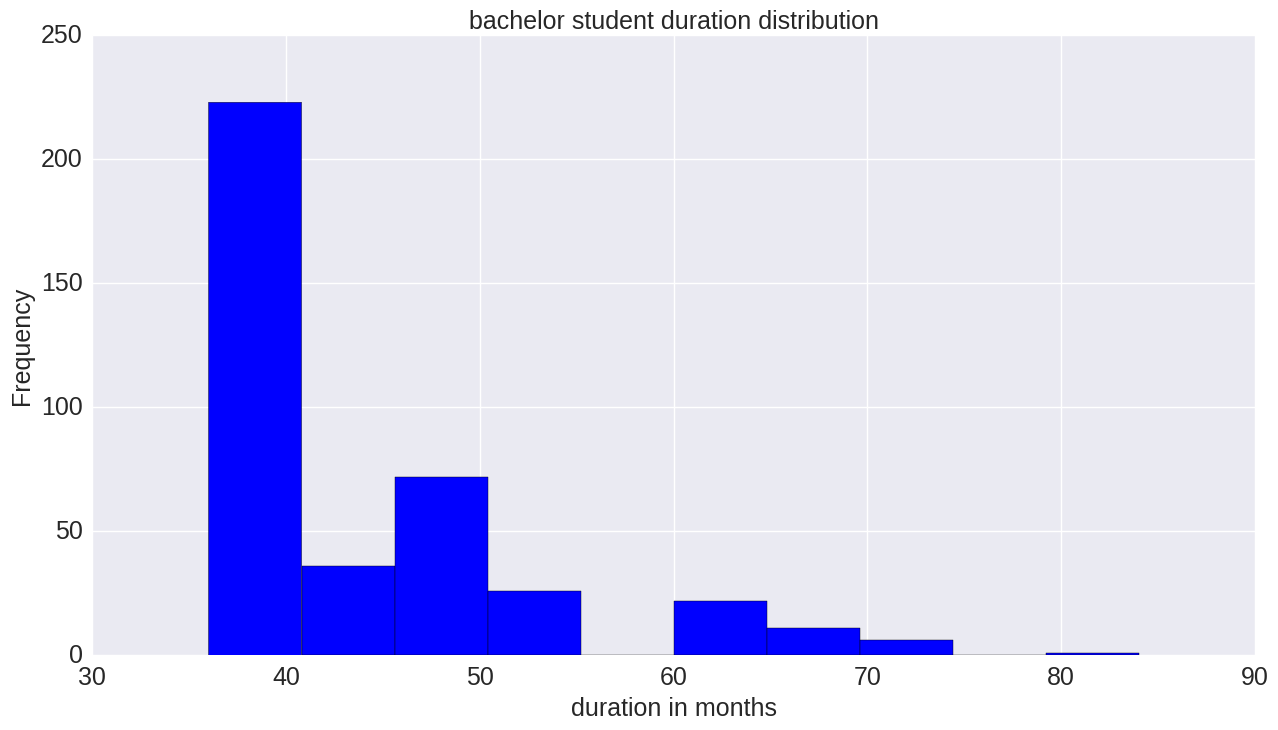

In [8]:
filtered.hist(column='duration', figsize=(15,8), color = 'blue')
plt.title('bachelor student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [9]:
madames_durations = filtered[filtered['gender'] == 'Madame']['duration']
monsieur_durations = filtered[filtered['gender'] == 'Monsieur']['duration']

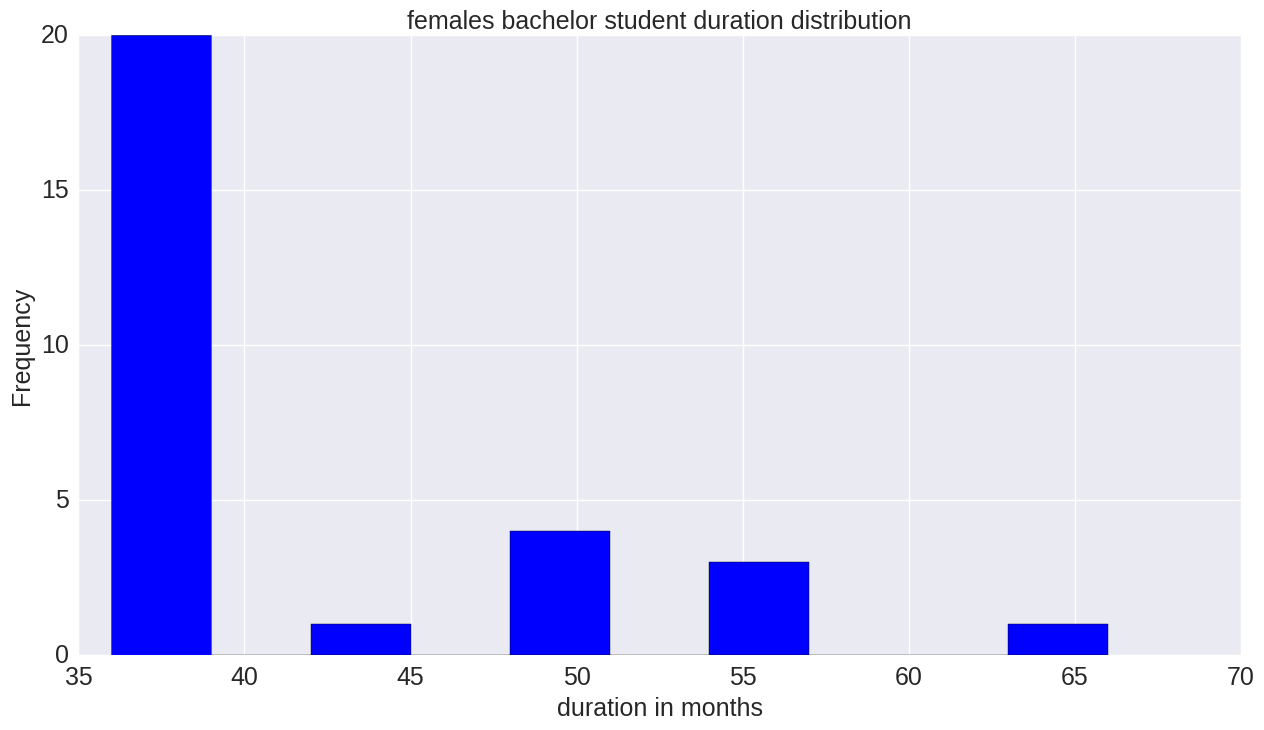

In [10]:
madames_durations.hist(figsize=(15,8), color = 'blue')
plt.title('females bachelor student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

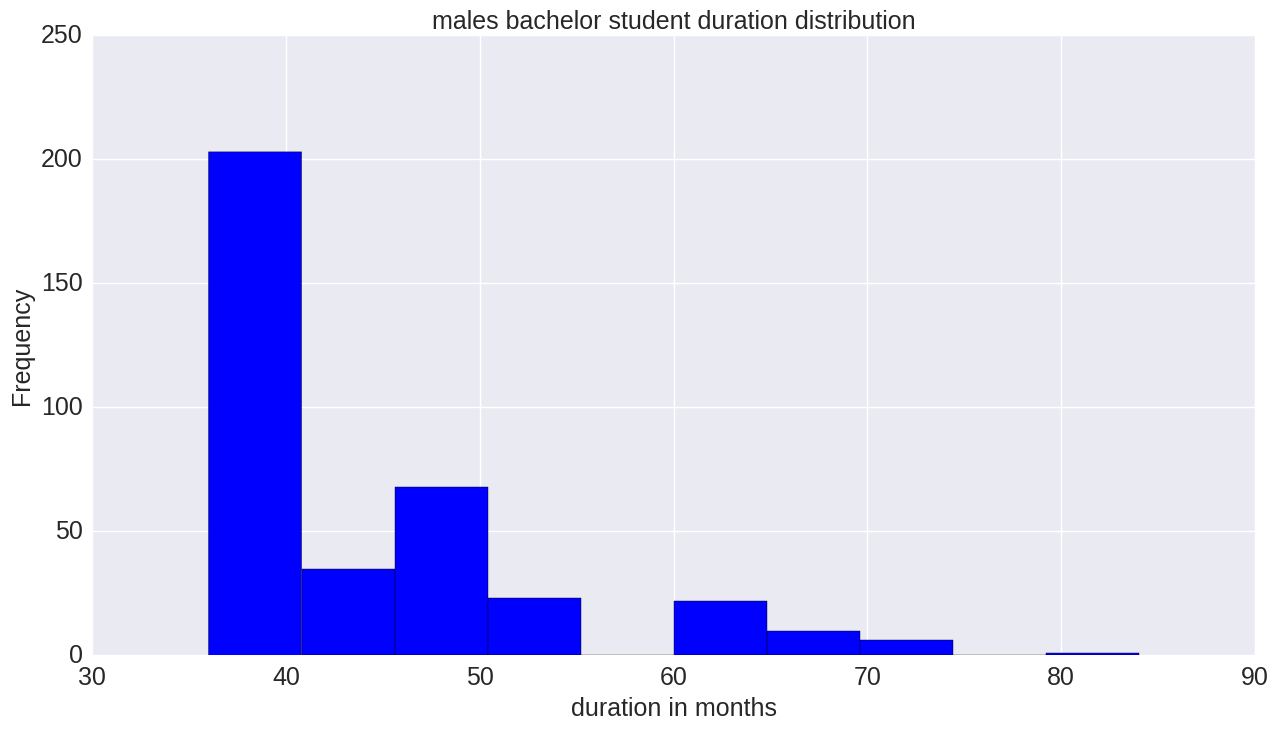

In [11]:
monsieur_durations.hist(figsize=(15,8), color = 'blue')
plt.title('males bachelor student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

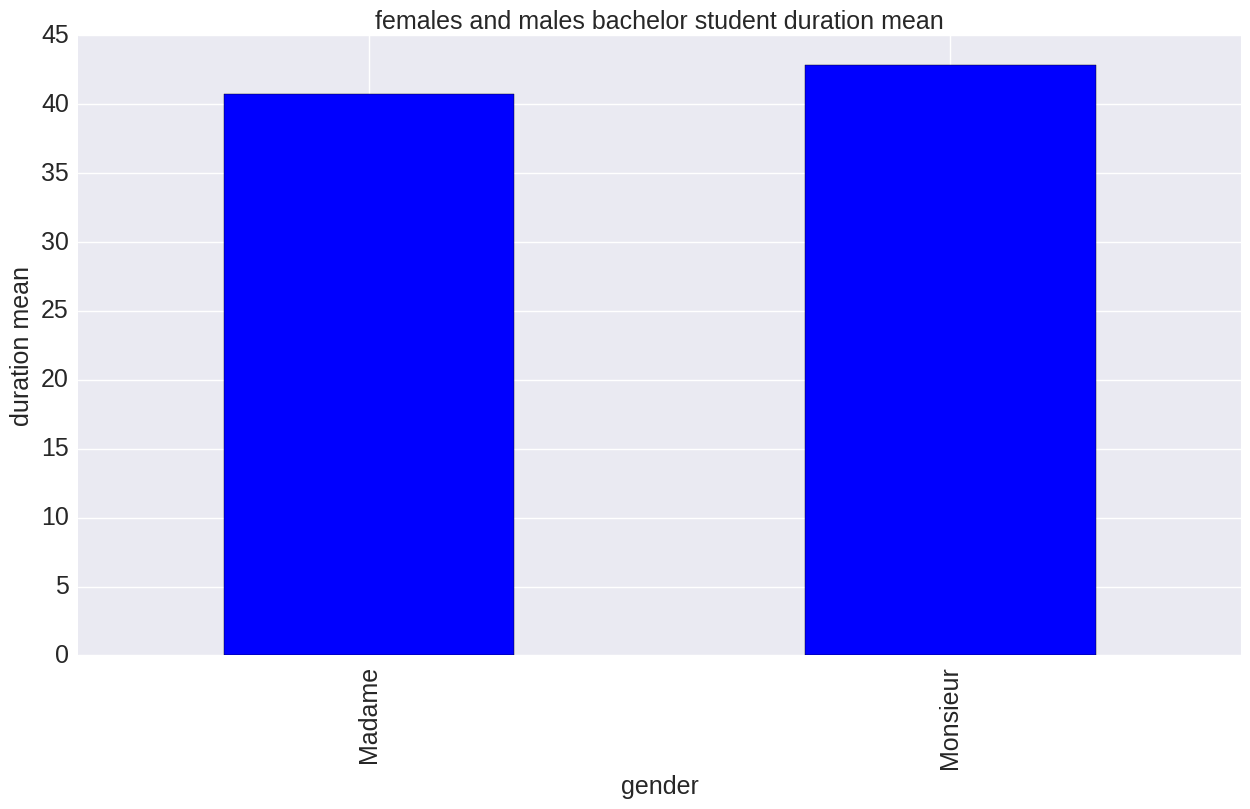

In [12]:
filtered.groupby('gender').duration.mean().plot(kind='bar', color='blue',figsize=(15,8))
plt.title('females and males bachelor student duration mean', fontsize=18)
plt.xlabel('gender', fontsize=18)
plt.ylabel('duration mean', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

### Data Normalization and Standardization:
Normalization refers to rescaling real valued numeric attributes into the range 0 and 1 and standardization refers to shifting the distribution of each attribute to have a mean of zero and a standard deviation of one (unit variance). We need this to perform K-S test since this test checks whether a distribution is normal by comparing it to a standardized normalized distribution.

In [13]:
def normalize_standardize(distribution):
    distribution_norm = (distribution - distribution.mean()) / (distribution.max() - distribution.min())
    distribution_norm_stand = (distribution_norm - distribution_norm.mean()) / distribution_norm.std()
    return distribution_norm_stand

madames_norm_stand = normalize_standardize(madames_durations)
monsieur_norm_stand = normalize_standardize(monsieur_durations)

### Plotting distributions for Normalized, Standardized Data

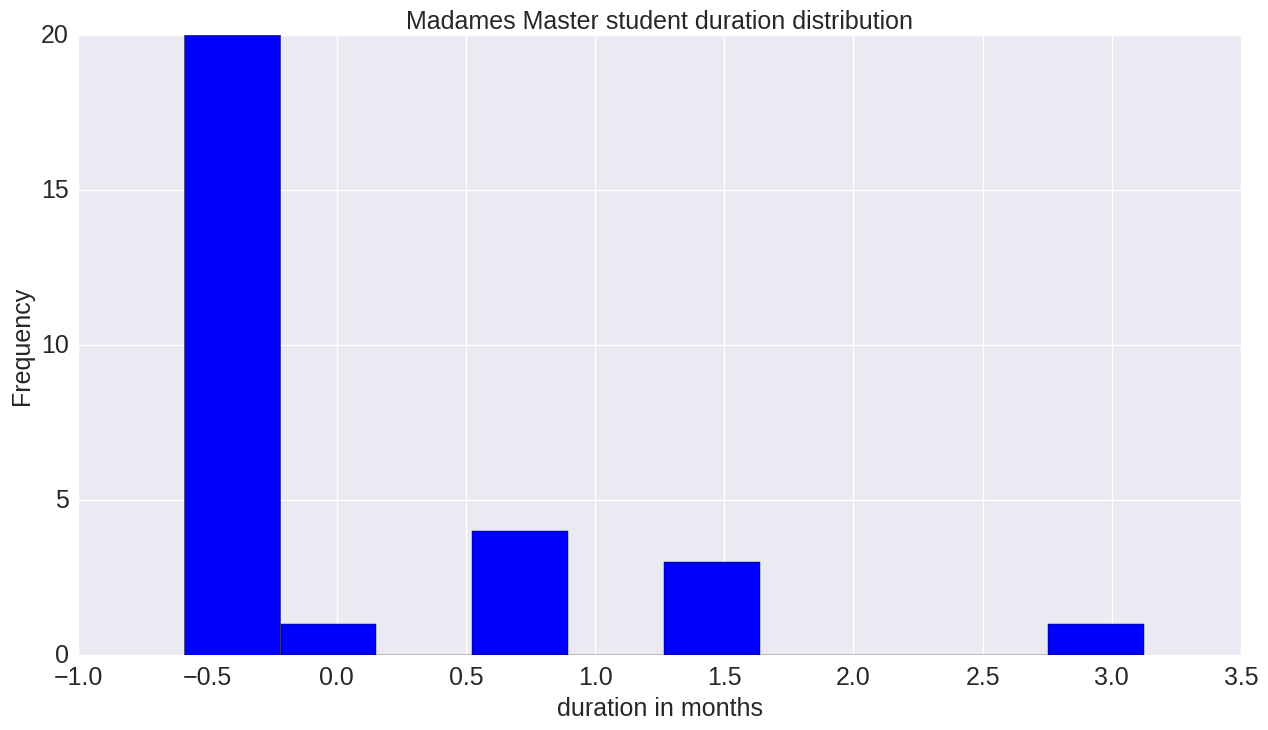

In [14]:
madames_norm_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Madames Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

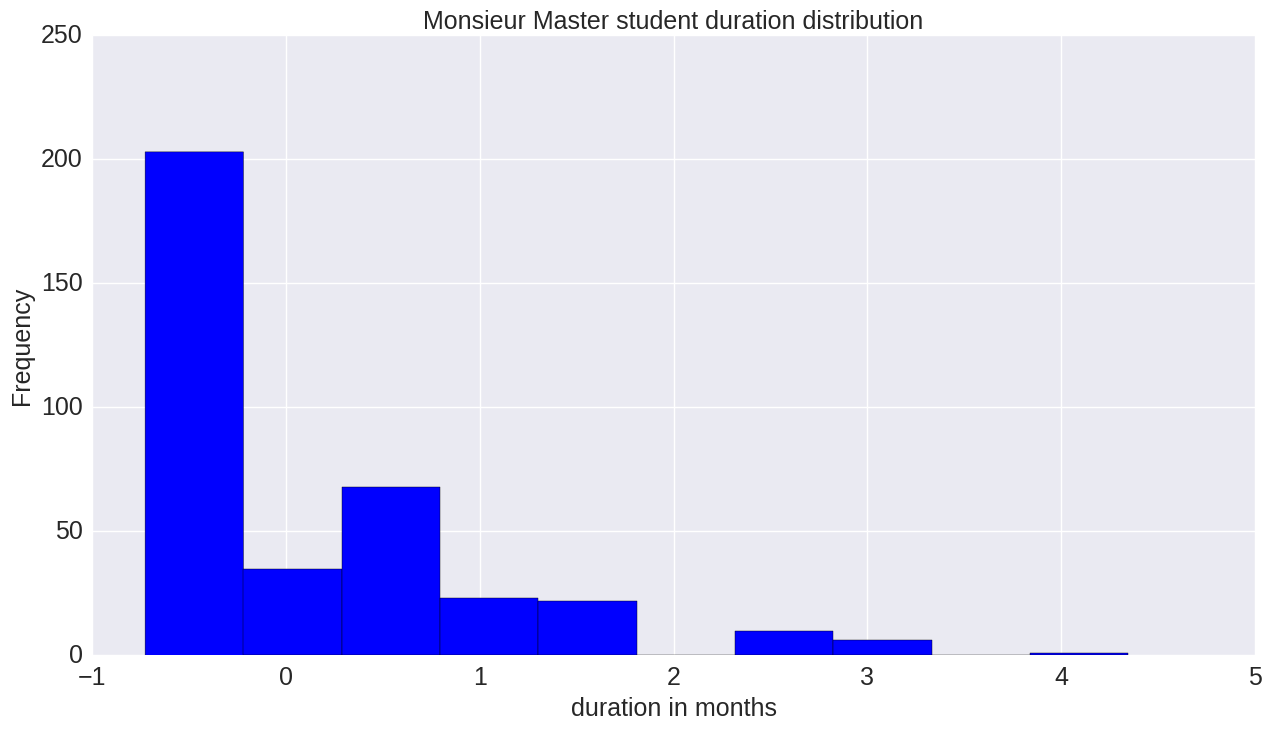

In [15]:
monsieur_norm_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Monsieur Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

### K-S (Kolmorogorov-Smirnov) test to check for Normal Distribution

In [16]:
stats.kstest(madames_norm_stand,'norm')

KstestResult(statistic=0.41174211903114533, pvalue=5.8119180432525397e-05)

Since the kstest returns a pvalue=5.8119180432525397e-05 (extremely smaller than 5%), we can reject with high confidence the null hypothesis that says that the bachelor duration for madames is a normal distribution => madames_norm_stand is not normal.

In [17]:
stats.kstest(monsieur_norm_stand,'norm')

KstestResult(statistic=0.31814448768829573, pvalue=0.0)

Since the kstest returns a pvalue=0.0 (extremely smaller than 5%),we can reject with high confidence the null hypothesis that says that the bachelor duration for monsieur is a normal distribution => monsieur_norm_stand is not normal.

Since the two samples are not normal, and we have unpaired independent samples (since we want to compare two different subjects and there is no correlation between males and females the duration that it takes for males to graduate doesn't make the duration for females to graduate), the most adequate to apply here is Mann-Whitney test.

In [142]:
stats.mannwhitneyu(madames_norm_stand, monsieur_norm_stand, use_continuity=True, alternative='two-sided')

MannwhitneyuResult(statistic=6876.0, pvalue=0.0052675951752590502)

Since pvalue=0.0052675951752590502 is less than the threshold of 5%, we can with a confidence greater than 95% reject the null hypothesis that says that the two samples have the same mean. So there is a significant statistical difference between males duration to graduate and females duration to graduate.

### Exercise 2: Masters Students

In [93]:

master_semesters = [
    ('2230106', 'Master semestre 1'),
    ('942192', 'Master semestre 2'),
    ('2230128', 'Master semestre 3'),
    ('2230140', 'Master semestre 4'),
    ('249127', 'Projet Master automne'),
    ('3781783', 'Projet Master printemps'),
]

masters_final_table = None

#frames = map(lambda x: grab_table(*x), itertools.product(master_semesters, year_tuples))
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    master_frames = executor.map(lambda x: grab_table(*x), itertools.product(master_semesters, year_tuples))
print("Finished")
master_frames = filter(lambda x : x is not None, master_frames)
for frame in master_frames:
    if masters_final_table is None:
        masters_final_table = frame
    else:
        #bachelors_final_table = pd.merge(table[['No Sciper', semester_col]], bachelors_final_table, left_on='No Sciper', right_on='No Sciper', how='outer')
        masters_final_table = pd.merge(frame, masters_final_table, how='outer')

masters_final_table.columns

Master semestre 1 2015 done
Master semestre 1 2013 done
Master semestre 1 2009 done
Master semestre 1 2016 done
Master semestre 1 2011 done
Master semestre 1 2007 done
Master semestre 2 2016 done
Master semestre 1 2008 done
Master semestre 2 2015 done
Master semestre 1 2014 done
Master semestre 2 2012 done
Master semestre 2 2010 done
Master semestre 2 2011 done
Master semestre 2 2009 done
Master semestre 2 2008 done
Master semestre 3 2016 done
Master semestre 3 2013 done
Master semestre 1 2012 done
Master semestre 3 2015 done
Master semestre 2 2013 done
Master semestre 2 2014 done
Master semestre 3 2012 done
Master semestre 3 2014 done
Master semestre 3 2008 done
Master semestre 3 2011 done
Master semestre 2 2007 done
Master semestre 1 2010 done
Master semestre 3 2007 done
Projet Master automne 2015 done
Projet Master automne 2013 done
Projet Master automne 2014 done
Projet Master automne 2012 done
Projet Master automne 2010 done
Projet Master automne 2011 done
Projet Master automne 20

,Civilité,Nom Prénom,Statut,No Sciper,Spécialisation,Projet Master printemps,Projet Master automne,Master semestre 3,Master semestre 2,Master semestre 1
1511,Monsieur,Guggenheim Daniel Vincent,Présent,224356,Data Analytics,NaN,NaN,2016.0,2015.0,NaN
1550,Madame,M'Hamdi Meryem,Présent,261006,Data Analytics,NaN,NaN,2016.0,NaN,NaN
1568,Monsieur,Parmantier Hector Andreas Alexandre,Présent,225757,Data Analytics,NaN,NaN,2016.0,2015.0,NaN
1586,Monsieur,Sarigiannis Dimitrios,Présent,256553,Data Analytics,NaN,NaN,2016.0,2015.0,NaN
1587,Monsieur,Sarigiannis Dimitrios,Présent,256553,Data Analytics,NaN,NaN,2016.0,NaN,2015.0
2314,Monsieur,Cartier Alexis Victor Xavier,Présent,202973,Data Analytics,NaN,NaN,NaN,2015.0,NaN
2315,Monsieur,Cartier Alexis Victor Xavier,Présent,202973,Data Analytics,NaN,NaN,NaN,NaN,2016.0
2392,Monsieur,Vallee Josselin André Jean,Présent,214573,Data Analytics,NaN,NaN,NaN,2015.0,NaN
2393,Monsieur,Vallee Josselin André Jean,Présent,214573,Data Analytics,NaN,NaN,NaN,NaN,2016.0
2676,Monsieur,Quinton Pierre Victor Xavier,Présent,224553,Data Analytics,NaN,NaN,NaN,NaN,2016.0


In [106]:
from pprint import pprint as pp

def masters_get_merged_(group):
    
    
    # To not count the students that only have entries in 'Project', we first temporarly have the table with MA1, MA2 and MA3
    # columns
    ma1_ma2_ma3 = group[['No Sciper', 'Master semestre 1', 'Master semestre 2', 'Master semestre 3']]
    ma1_ma2_ma3 = ma1_ma2_ma3.dropna(subset=['Master semestre 1', 'Master semestre 2', 'Master semestre 3'], how='all')
    project_entries = group[['No Sciper','Projet Master printemps', 'Projet Master automne']]
    project_entries = project_entries.dropna(subset=['Projet Master printemps', 'Projet Master automne'], how='all')
    project_entries = project_entries.drop_duplicates(subset=['Projet Master printemps', 'Projet Master automne'])
    spec_table = group[['Spécialisation']].dropna(subset=['Spécialisation'])
    
    if len(spec_table) > 0:
        spec = spec_table.iloc[0]['Spécialisation']
    else:
        spec = None
    
    
    #Drop the groups (enrollment record of a single person) which doesn't include Master Semester 1
    if len(group.dropna(subset=['Master semestre 1'])) > 0 and len(ma1_ma2_ma3) > 1:
        
        #ending = max(group[['Master semestre 2','Master semestre 3','Projet Master automne', 'Projet Master printemps']].max(axis=0))
        
        starting = min(group[['Master semestre 1', 'Master semestre 2']].min(axis=0))
        
        duration = len(ma1_ma2_ma3)
        
        project_time = max(6,len(project_entries)*6)
        #pp(ma1_ma2_ma3)
        #print(starting,ending)
        #return group
        
        ma1_ma2_ma3 = ma1_ma2_ma3.dropna(subset=['Master semestre 1', 'Master semestre 2', 'Master semestre 3'], how='all')
        
        return pd.DataFrame({
            "No Sciper": group.iloc[0]['No Sciper'],
            "duration": duration*6,
            'project_time': project_time,
            'start_year': starting,
            'total_duration': project_time+duration*6,
            "gender": group.iloc[0]['Civilité'],
            'specialization': spec
        }, index=['No Sciper'])
    return pd.DataFrame([])

masters_grouped = masters_final_table.groupby('No Sciper')
masters_filtered = masters_grouped.apply(masters_get_merged_)

masters_filtered.describe()

## TODOO...

#138088
#masters_final_table[masters_final_table['No Sciper'] == '146742']
masters_filtered.head()
#masters_filtered[masters_filtered['project_time'] == 12]

,,No Sciper,duration,gender,project_time,specialization,start_year,total_duration
No Sciper,,,,,,,,
146330,No Sciper,146330,18.0,Monsieur,6.0,None,2007.0,24.0
146742,No Sciper,146742,30.0,Monsieur,12.0,"Signals, Images and Interfaces",2008.0,42.0
146929,No Sciper,146929,12.0,Monsieur,6.0,None,2007.0,18.0
147008,No Sciper,147008,24.0,Monsieur,6.0,"Signals, Images and Interfaces",2011.0,30.0
152232,No Sciper,152232,18.0,Monsieur,6.0,None,2007.0,24.0


In [109]:
aa=masters_filtered

In [110]:
len(aa)

764

In [115]:
aa['specialization'].unique()

array([None, 'Signals, Images and Interfaces', 'Internet computing',
       'Biocomputing', 'Foundations of Software',
       'Computer Engineering - SP', 'Service science', 'Software Systems',
       'Information Security - SP', 'Data Analytics',
       'Internet Information Systems', 'Computer Science Theory'], dtype=object)

In [112]:
df_Signals=aa[aa['specialization']=='Signals, Images and Interfaces']
df_Internetcomputing=aa[aa['specialization']=='Internet computing']
df_Biocomputing=aa[aa['specialization']=='Biocomputing']
df_FoundationsofSoftware=aa[aa['specialization']=='Foundations of Software']
df_ComputerEngineering=aa[aa['specialization']=='Computer Engineering - SP']
df_Servicescience=aa[aa['specialization']=='Service science']
df_SoftwareSystems=aa[aa['specialization']=='Software Systems']
df_InformationSecurity=aa[aa['specialization']=='Information Security - SP']
df_DataAnalytics=aa[aa['specialization']=='Data Analytics']
df_InternetInformationSystems=aa[aa['specialization']=='Internet Information Systems']
df_ComputerScienceTheory=aa[aa['specialization']=='Computer Science Theory']

In [113]:
general_dur = aa['total_duration']
df_Signals_dur = df_Signals['total_duration']
df_Internetcomputing_dur = df_Internetcomputing['total_duration']
df_Biocomputing_dur = df_Biocomputing['total_duration']
df_FoundationsofSoftware_dur = df_FoundationsofSoftware['total_duration']
df_ComputerEngineering_dur = df_ComputerEngineering['total_duration']
df_Servicescience_dur = df_Servicescience['total_duration']
df_SoftwareSystems_dur = df_SoftwareSystems['total_duration']
df_InformationSecurity_dur = df_InformationSecurity['total_duration']
df_DataAnalytics_dur = df_DataAnalytics['total_duration']
df_InternetInformationSystems_dur = df_InternetInformationSystems['total_duration']
df_ComputerScienceTheory_dur = df_ComputerScienceTheory['total_duration']

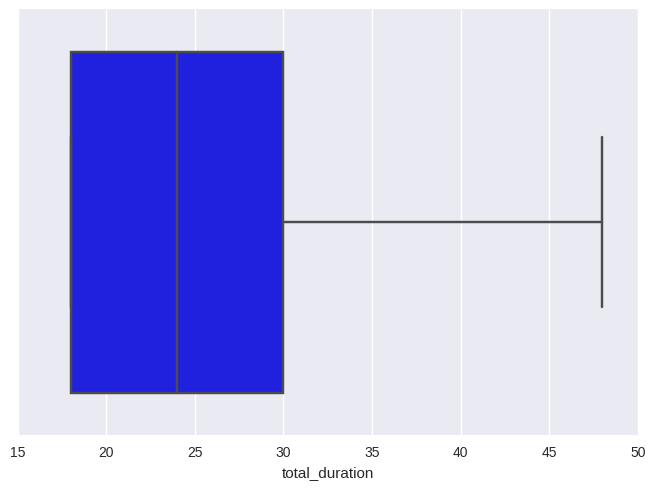

In [26]:
sns.boxplot(aa.total_duration, showfliers=False, color = 'blue')


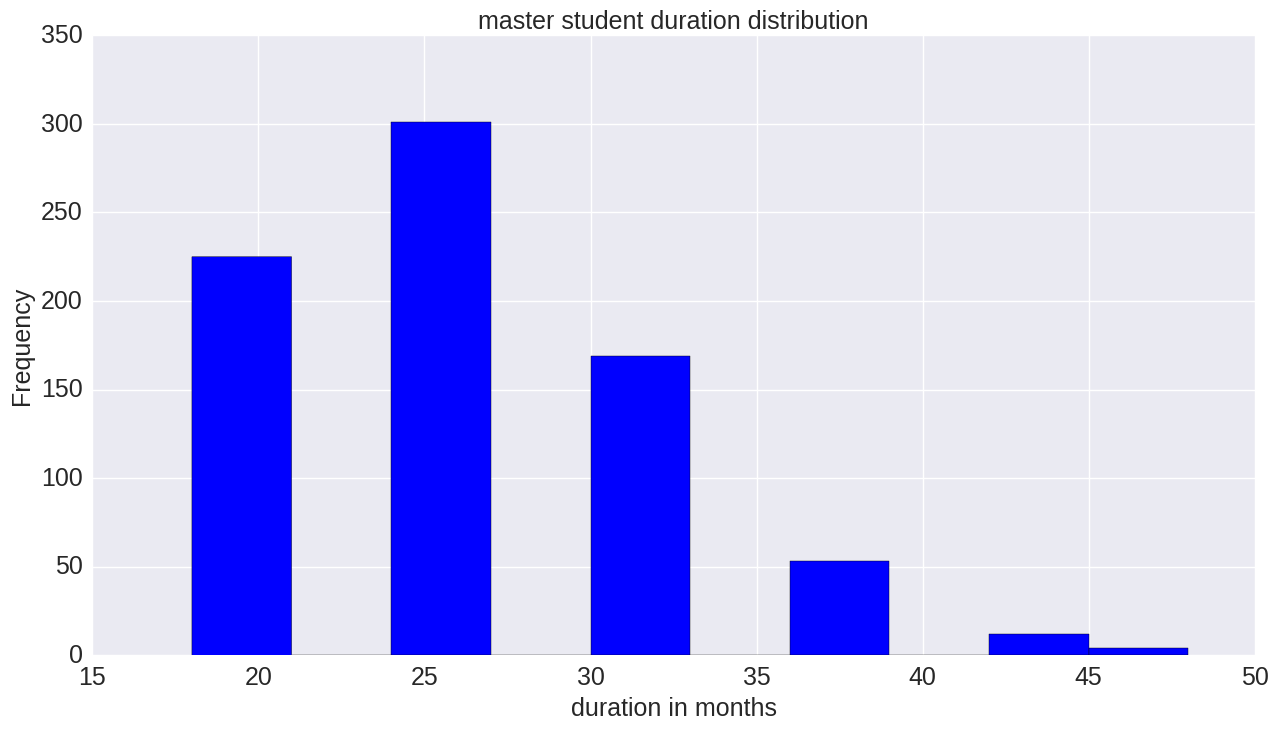

In [27]:
aa.hist(column='total_duration',figsize=(15,8), color = 'blue')
plt.title('master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [138]:
general_dur.mean()

24.801047120418847

In [139]:
aa1=aa.reset_index(drop=True)
aa1

,No Sciper,duration,gender,project_time,specialization,start_year,total_duration
0,146330,18.0,Monsieur,6.0,None,2007.0,24.0
1,146742,30.0,Monsieur,12.0,"Signals, Images and Interfaces",2008.0,42.0
2,146929,12.0,Monsieur,6.0,None,2007.0,18.0
3,147008,24.0,Monsieur,6.0,"Signals, Images and Interfaces",2011.0,30.0
4,152232,18.0,Monsieur,6.0,None,2007.0,24.0
5,153066,36.0,Monsieur,6.0,Internet computing,2007.0,42.0
6,153746,18.0,Monsieur,6.0,None,2007.0,24.0
7,153762,24.0,Monsieur,6.0,None,2008.0,30.0
8,154080,30.0,Monsieur,6.0,Internet computing,2007.0,36.0
9,154573,30.0,Madame,6.0,Biocomputing,2007.0,36.0


### Data Normalization and Standardization

In [143]:
general_dur_stand = normalize_standardize(general_dur)
df_Signals_dur_stand = normalize_standardize(df_Signals_dur)
df_Internetcomputing_dur_stand = normalize_standardize(df_Internetcomputing_dur)
df_Biocomputing_dur_stand = normalize_standardize(df_Biocomputing_dur)
df_FoundationsofSoftware_dur_stand = normalize_standardize(df_FoundationsofSoftware_dur)
df_ComputerEngineering_dur_stand = normalize_standardize(df_ComputerEngineering_dur)
df_Servicescience_dur_stand = normalize_standardize(df_Servicescience_dur)
df_SoftwareSystems_dur_stand = normalize_standardize(df_SoftwareSystems_dur)
df_InformationSecurity_dur_stand = normalize_standardize(df_InformationSecurity_dur)
df_DataAnalytics_dur_stand = normalize_standardize(df_DataAnalytics_dur)
df_InternetInformationSystems_dur_stand = normalize_standardize(df_InternetInformationSystems_dur)
df_ComputerScienceTheory_dur_stand = normalize_standardize(df_ComputerScienceTheory_dur)

### Plotting distributions for Normalized, Standardized Data

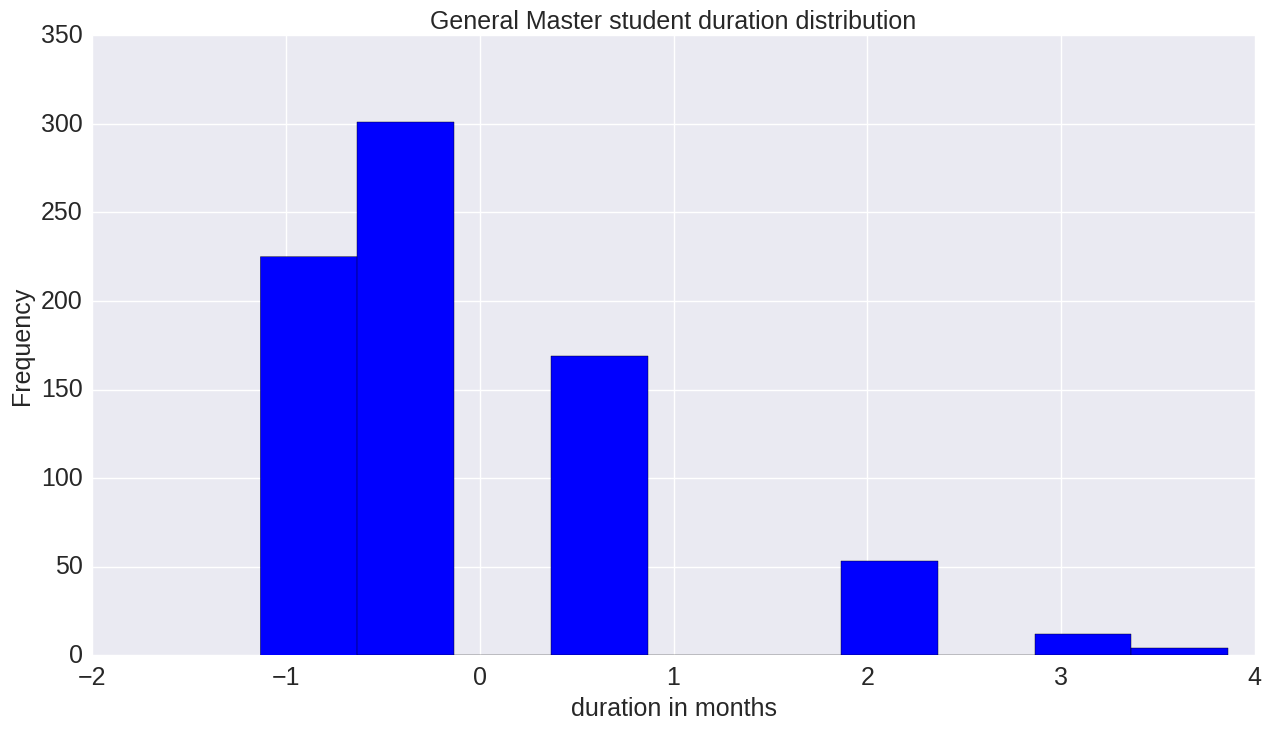

In [77]:
general_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('General Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

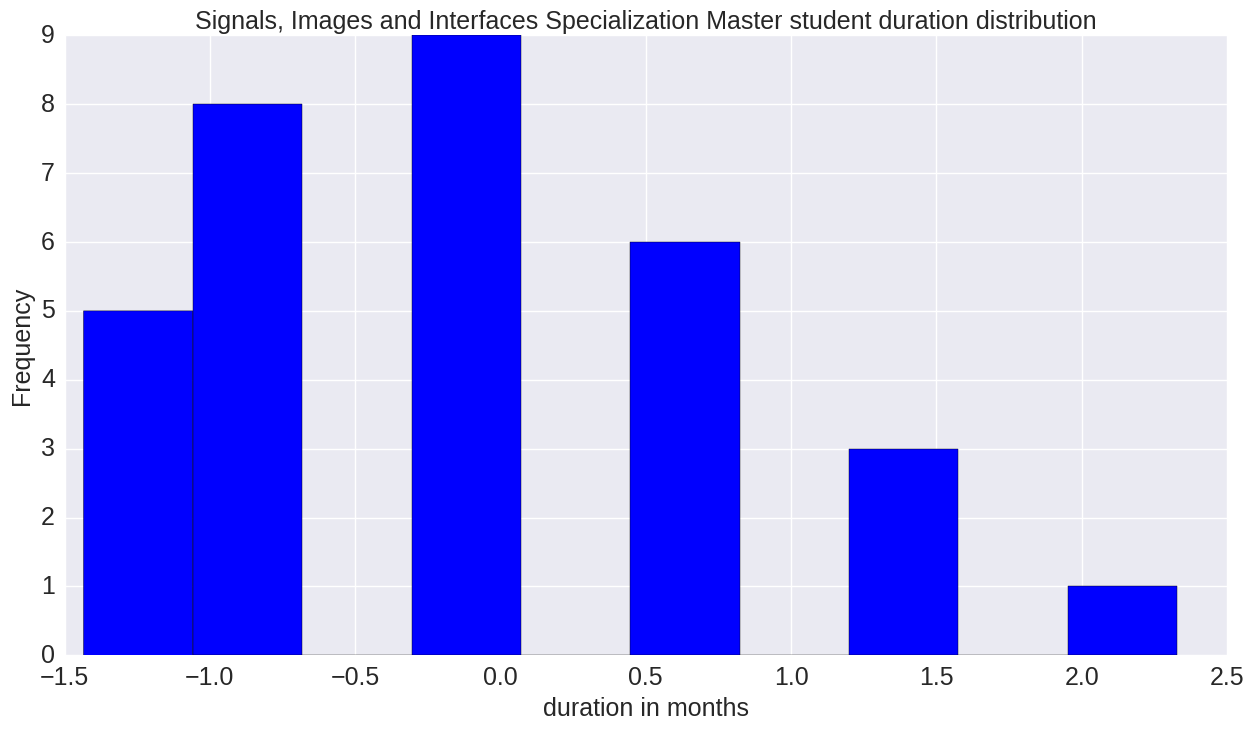

In [78]:
df_Signals_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Signals, Images and Interfaces Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

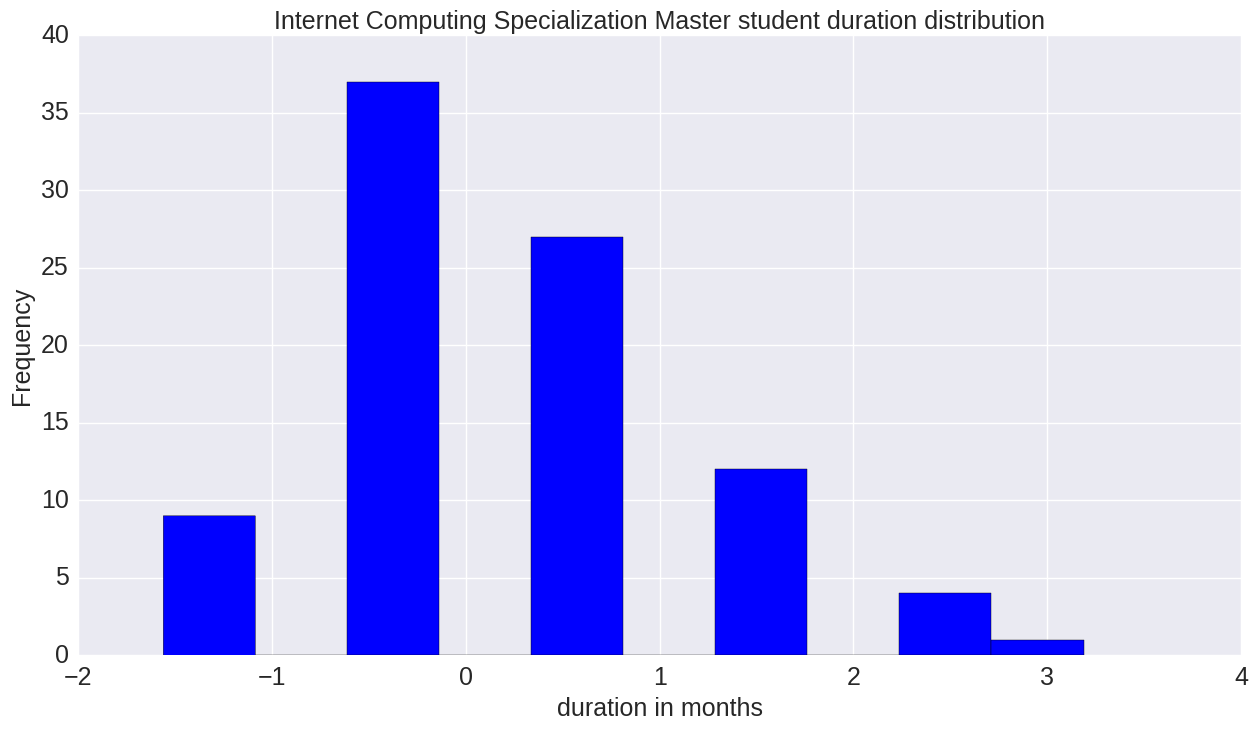

In [79]:
df_Internetcomputing_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Internet Computing Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

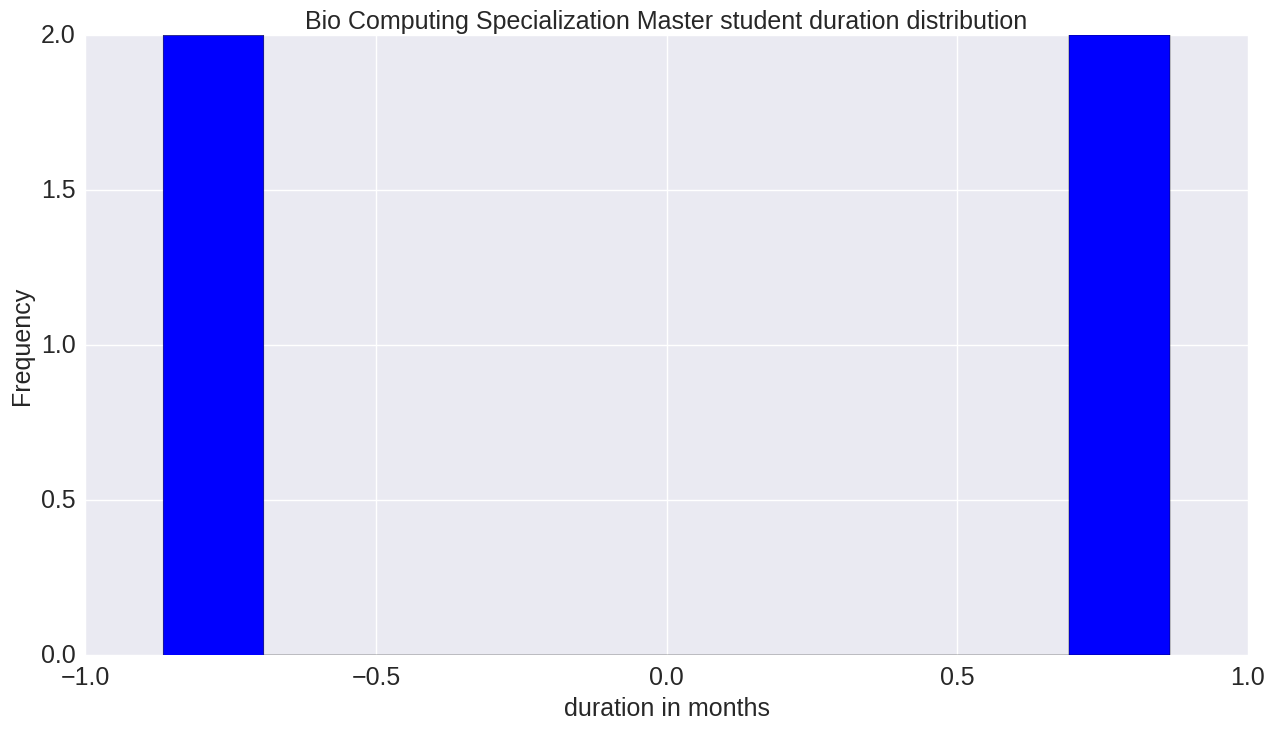

In [80]:
df_Biocomputing_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Bio Computing Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

No Sciper           
160718     No Sciper    24.0
161357     No Sciper    24.0
161794     No Sciper    24.0
165819     No Sciper    24.0
166124     No Sciper    30.0
166229     No Sciper    24.0
166263     No Sciper    24.0
166264     No Sciper    24.0
166746     No Sciper    24.0
166935     No Sciper    24.0
170226     No Sciper    30.0
170267     No Sciper    30.0
170823     No Sciper    24.0
171084     No Sciper    24.0
175012     No Sciper    36.0
175339     No Sciper    36.0
175702     No Sciper    24.0
175713     No Sciper    24.0
177399     No Sciper    24.0
178682     No Sciper    42.0
179194     No Sciper    30.0
179703     No Sciper    36.0
183895     No Sciper    18.0
184342     No Sciper    24.0
185934     No Sciper    30.0
186060     No Sciper    24.0
186250     No Sciper    36.0
191181     No Sciper    30.0
192927     No Sciper    30.0
193046     No Sciper    30.0
                        ... 
193894     No Sciper    30.0
194182     No Sciper    42.0
196065     No Sciper  

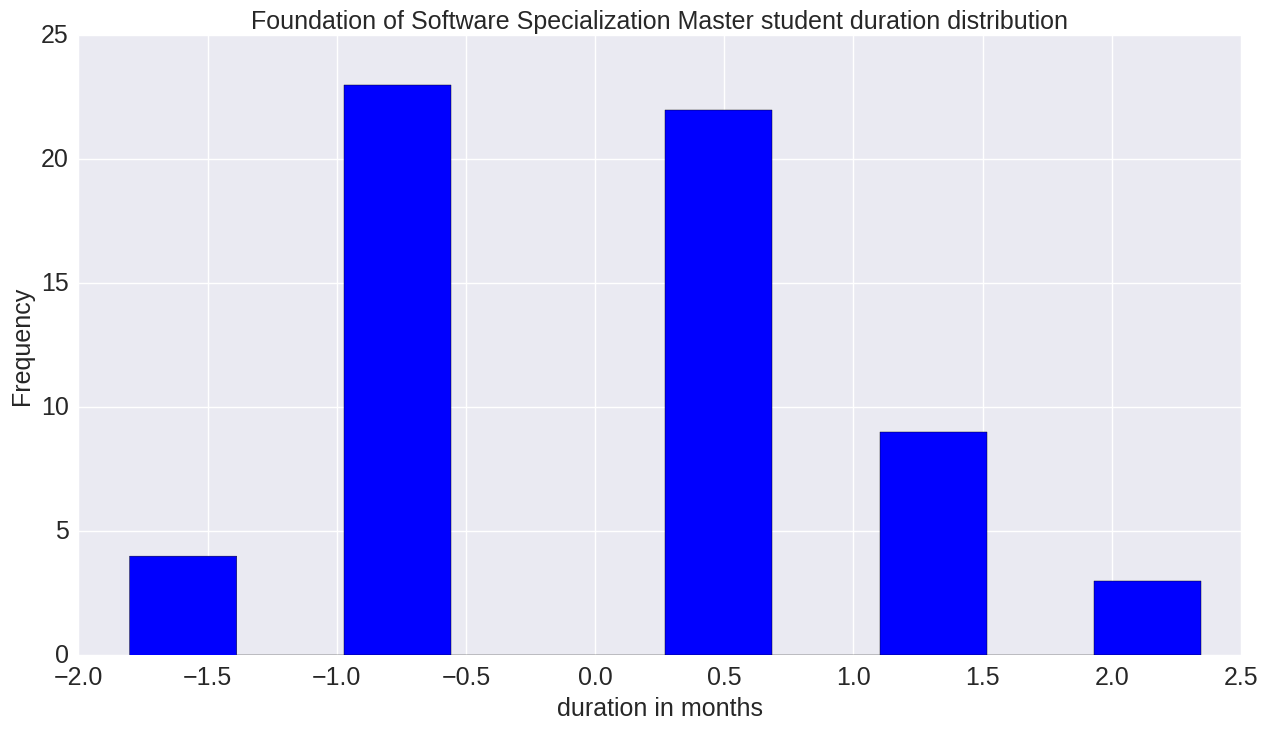

In [90]:
df_FoundationsofSoftware_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Foundation of Software Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

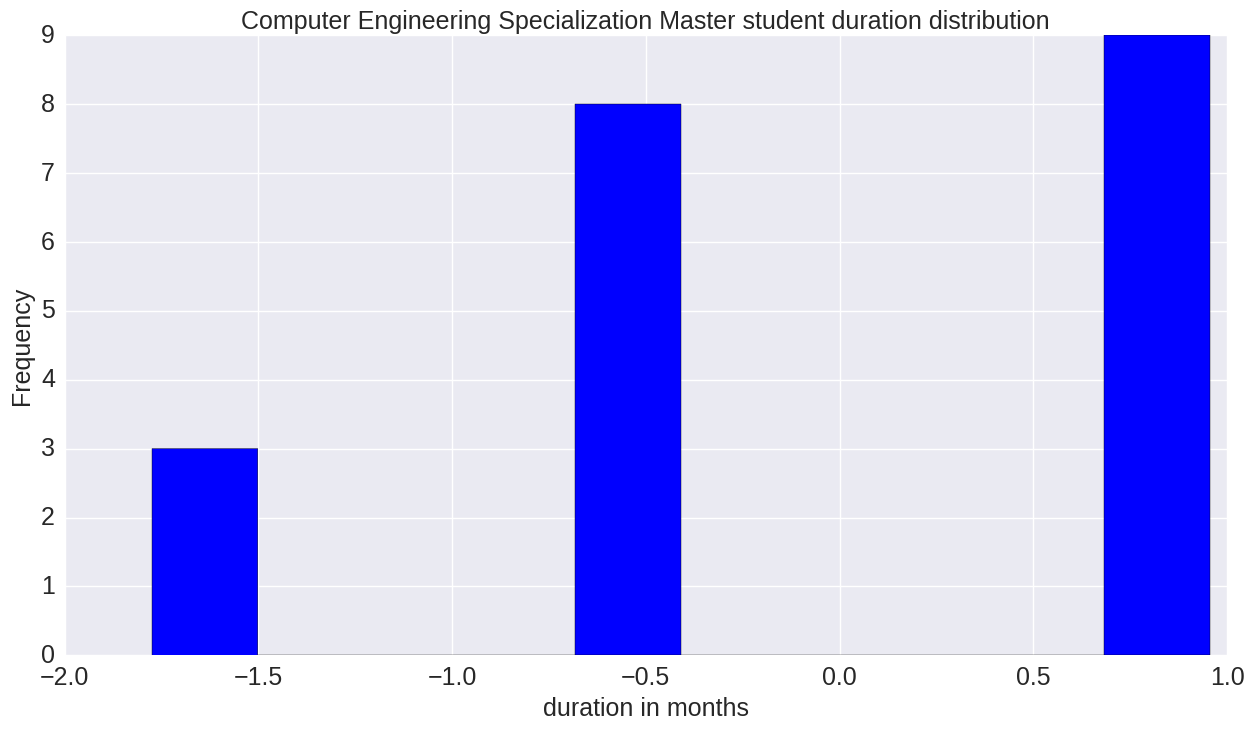

In [82]:
df_ComputerEngineering_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Computer Engineering Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

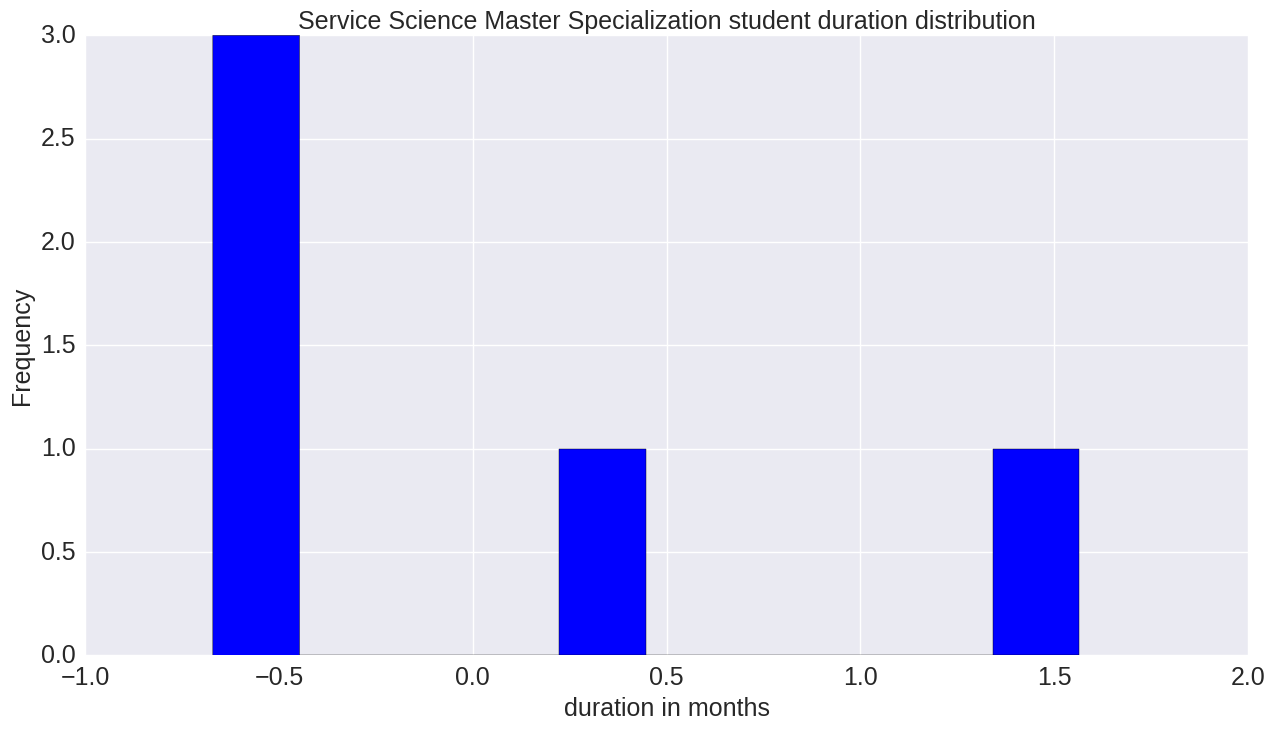

In [83]:
df_Servicescience_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Service Science Master Specialization student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

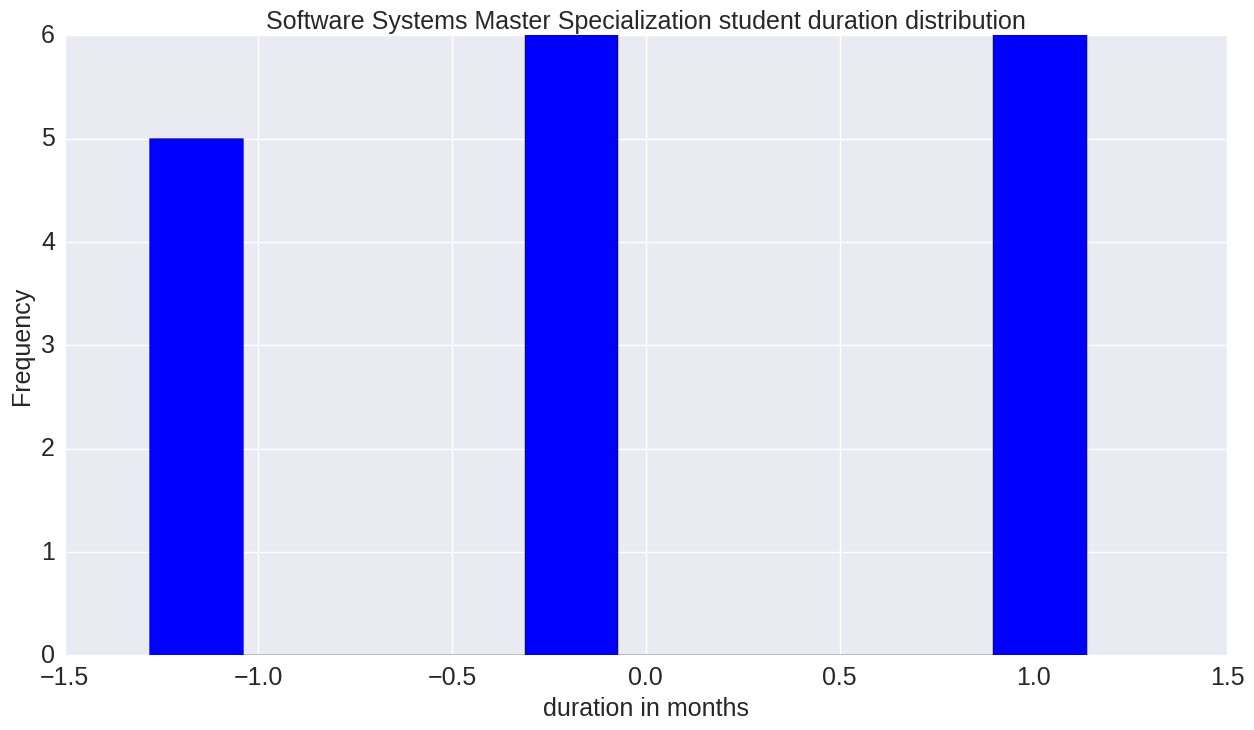

In [84]:
df_SoftwareSystems_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Software Systems Master Specialization student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

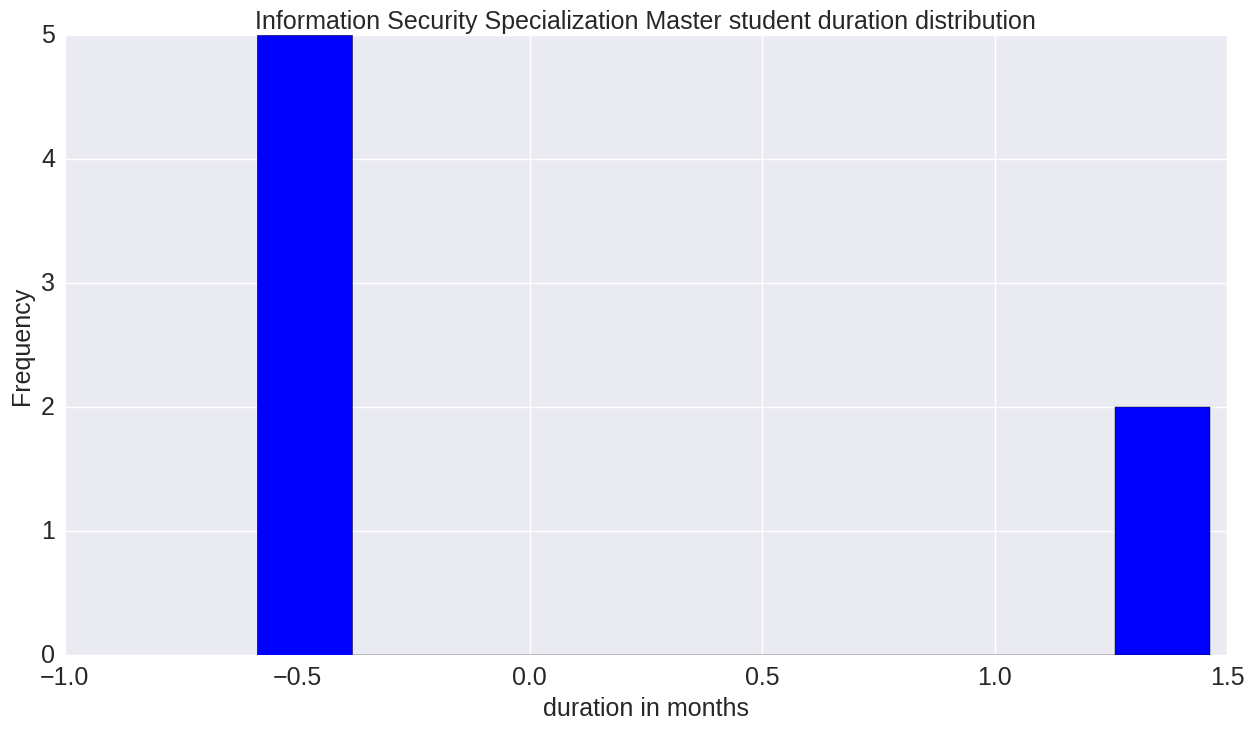

In [85]:
df_InformationSecurity_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Information Security Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

No Sciper           
202973     No Sciper    18.0
214573     No Sciper    24.0
224356     No Sciper    18.0
225757     No Sciper    18.0
256553     No Sciper    18.0
Name: total_duration, dtype: float64

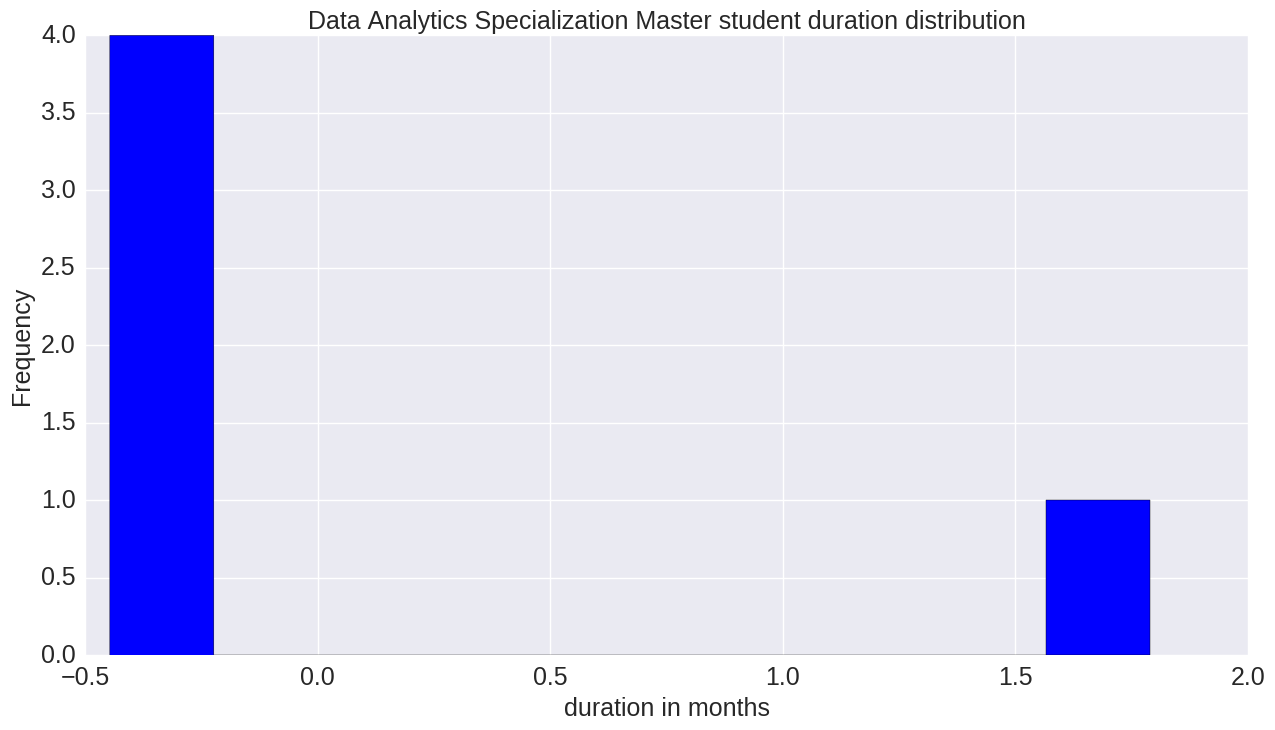

In [89]:
df_DataAnalytics_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Data Analytics Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

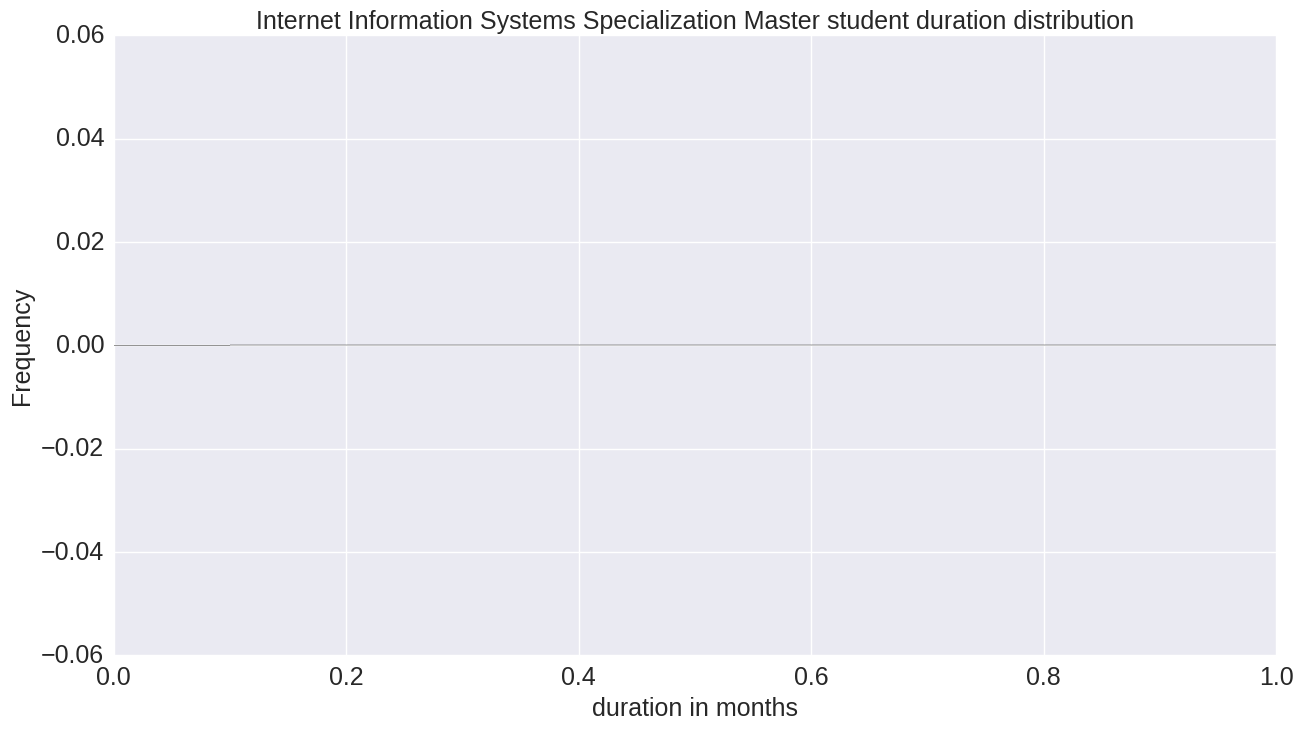

In [87]:
df_InternetInformationSystems_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Internet Information Systems Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

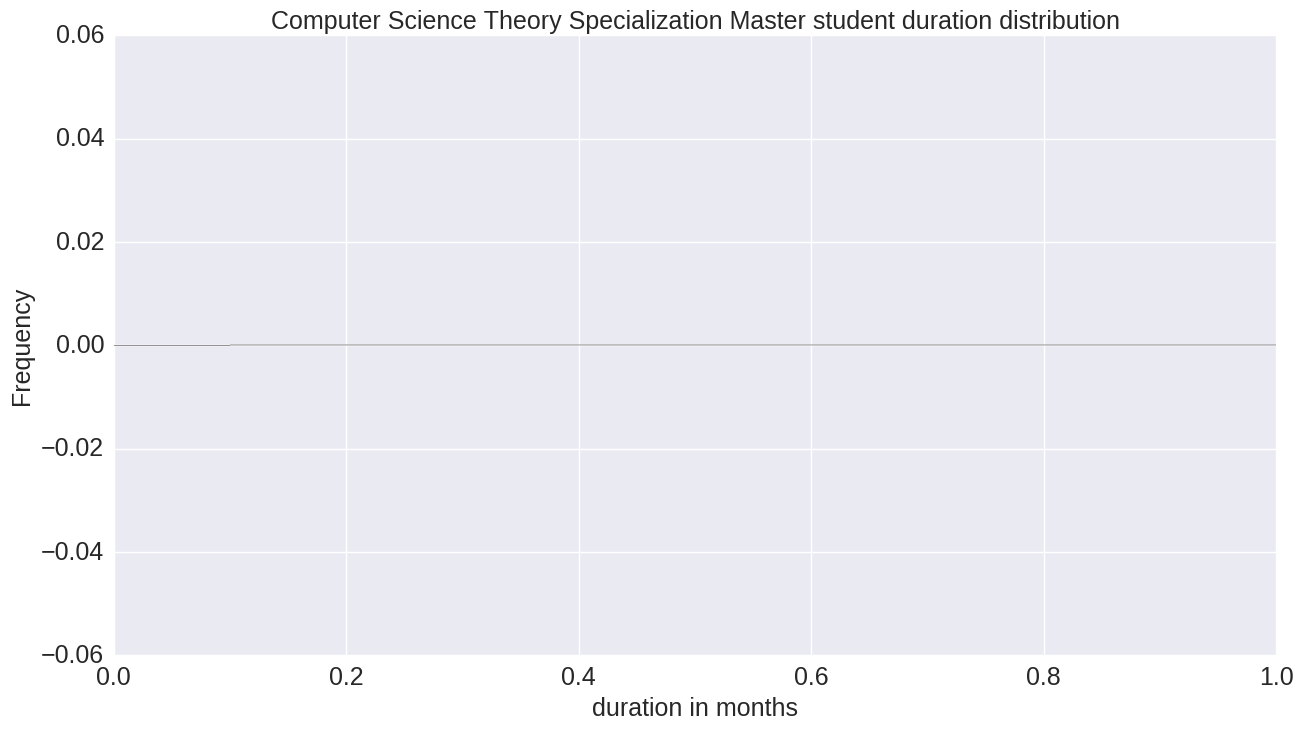

In [88]:
df_ComputerScienceTheory_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Computer Science Theory Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

### Performing Kolmogorov-Smirnov Test to see whether Distribution is Normal

In [117]:
kstest(general_dur_stand,'norm')

KstestResult(statistic=0.24153804819003255, pvalue=0.0)

Since the p-value = 0, we can reject the null hypothesis which states that general duration is identical to a gaussian normal distribution. So, general duration is not normal distribution.

In [118]:
kstest(df_Signals_dur_stand,'norm')

KstestResult(statistic=0.15937232655976097, pvalue=0.3545204651001661)

Since the p-value = 0.3545204651001661, we cannot reject the null hypothesis which states that general duration is identical to a gaussian normal distribution. So, Signals, Images and Interfaces duration is normal distribution.

In [129]:
kstest(df_Internetcomputing_dur_stand,'norm')

KstestResult(statistic=0.24090828313347257, pvalue=4.4092634343240178e-05)

Since the p-value = pvalue=4.4092634343240178e-05, we cannot reject the null hypothesis which states that general duration is identical to a gaussian normal distribution. So, Internet Computing duration is not normal distribution.

In [130]:
kstest(df_Biocomputing_dur_stand,'norm')

KstestResult(statistic=0.30676188461438364, pvalue=0.84588519025943321)

Since the p-value = pvalue=0.84588519025943321, we cannot reject the null hypothesis which states that general duration is identical to a gaussian normal distribution. So, Bio Computing duration is a normal distribution.

In [131]:
kstest(df_FoundationsofSoftware_dur_stand,'norm')

KstestResult(statistic=0.22046987736635076, pvalue=0.0043856485510029852)

Since the p-value = pvalue=0.0043856485510029852, we can safely reject the null hypothesis which states that general duration is identical to a gaussian normal distribution. So, Foundations of Software duration is a not normal distribution.

In [132]:
kstest(df_ComputerEngineering_dur_stand,'norm')

KstestResult(statistic=0.28030644446237596, pvalue=0.069880855702021405)

Since the p-value = pvalue=0.069880855702021405, we cannot reject the null hypothesis which states that general duration is identical to a gaussian normal distribution. So, Computer Engineering duration is a normal distribution.

In [133]:
kstest(df_Servicescience_dur_stand,'norm')

KstestResult(statistic=0.34883252281974891, pvalue=0.47790658312647039)

Since the p-value = pvalue=0.47790658312647039, we cannot reject the null hypothesis which states that general duration is identical to a gaussian normal distribution. So, Service Science duration is a normal distribution.

In [124]:
kstest(df_SoftwareSystems_dur_stand,'norm')

KstestResult(statistic=0.22541199756756802, pvalue=0.3063845826512166)

Since the p-value = pvalue=0.3063845826512166, we cannot reject the null hypothesis which states that general duration is identical to a gaussian normal distribution. So, Software Systems duration is a normal distribution.

In [134]:
kstest(df_InformationSecurity_dur_stand,'norm')

KstestResult(statistic=0.43519338957438558, pvalue=0.10119881544670628)

Since the p-value = pvalue=0.10119881544670628, we cannot reject the null hypothesis which states that general duration is identical to a gaussian normal distribution. So, Information Security duration is a normal distribution.

In [135]:
kstest(df_DataAnalytics_dur_stand,'norm')

KstestResult(statistic=0.47263957699071146, pvalue=0.15289748833456063)

Since the p-value = pvalue=0.15289748833456063, we cannot reject the null hypothesis which states that general duration is identical to a gaussian normal distribution. So, Data Analytics duration is a normal distribution.

In [136]:
kstest(df_InternetInformationSystems_dur_stand,'norm')

KstestResult(statistic=nan, pvalue=nan)

In [137]:
kstest(df_ComputerScienceTheory_dur_stand,'norm')

KstestResult(statistic=nan, pvalue=nan)

Now, let's investigate for statistical differences between the average of each specialization and the general average for all specializations. Since, students from each specialization also belong to the general duration dataframe (part of the whole relationship), we can say that they are dependent. So, we are dealing here with paired samples and the most adequate test is a wilcoxon matched pairs test.

In [140]:
stats.wilcoxon(general_dur, df_Signals_dur, zero_method='wilcox', correction=False)

ValueError: Unequal N in wilcoxon.  Aborting.

In [36]:
stats.wilcoxon(general_dur, df_Internetcomputing_dur , zero_method='wilcox', correction=False)

Ttest_indResult(statistic=-4.555324209320645, pvalue=5.9934131304556089e-06)

In [37]:
stats.wilcoxon(general_dur, df_Biocomputing_dur, zero_method='wilcox', correction=False)

Ttest_indResult(statistic=-1.7257839794652425, pvalue=0.084789554599280018)

In [38]:
stats.wilcoxon(general_dur, df_FoundationsofSoftware_dur, zero_method='wilcox', correction=False)

Ttest_indResult(statistic=-4.5489075810562758, pvalue=6.2036451290649428e-06)

In [39]:
stats.wilcoxon(general_dur, df_ComputerEngineering_dur, zero_method='wilcox', correction=False)

Ttest_indResult(statistic=-0.7385280910631068, pvalue=0.46041518867225095)

In [40]:
stats.wilcoxon(general_dur, df_Servicescience_dur, zero_method='wilcox', correction=False)

Ttest_indResult(statistic=-1.0393171245617119, pvalue=0.29898478764822378)

In [41]:
stats.wilcoxon(general_dur, df_SoftwareSystems_dur, zero_method='wilcox', correction=False)

Ttest_indResult(statistic=0.30528282176362936, pvalue=0.76023230943792064)

In [42]:
stats.wilcoxon(general_dur, df_InformationSecurity_dur, zero_method='wilcox', correction=False)

Ttest_indResult(statistic=1.4793014650653615, pvalue=0.13946927216856539)

In [43]:
stats.wilcoxon(general_dur, df_DataAnalytics_dur, zero_method='wilcox', correction=False)

Ttest_indResult(statistic=2.0830598126568272, pvalue=0.037576457618531275)

In [44]:
stats.wilcoxon(general_dur, df_InternetInformationSystems_dur, zero_method='wilcox', correction=False)

/home/meryem/miniconda2/envs/py3k/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


Ttest_indResult(statistic=nan, pvalue=nan)

In [45]:
stats.wilcoxon(general_dur, df_ComputerScienceTheory_dur, zero_method='wilcox', correction=False)

/home/meryem/miniconda2/envs/py3k/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


Ttest_indResult(statistic=nan, pvalue=nan)

### Bonus Excercise ..

In [46]:
female_master_dur = aa1[aa1['gender'] == 'Madame']['total_duration']
male_master_dur = aa1[aa1['gender'] == 'Monsieur']['total_duration']
stats.ttest_ind(female_master_dur, male_master_dur)

Ttest_indResult(statistic=0.48166298285926606, pvalue=0.63018367378934903)

In [47]:
data_female = aa1[aa1['gender'] == 'Madame']
data_male = aa1[aa1['gender'] == 'Monsieur']



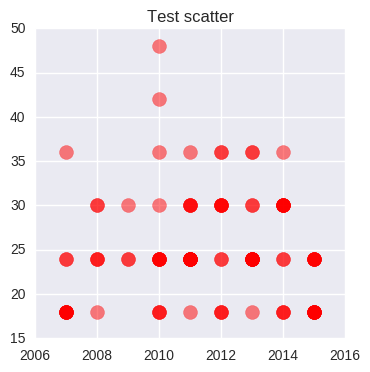

In [48]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, title="Test scatter")
ax.scatter(data_female['start_year'], data_female['total_duration'], s=100, color="red", alpha=0.5)



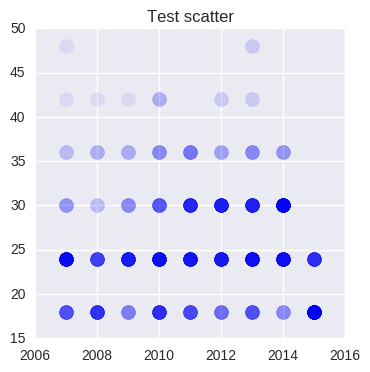

In [49]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, title="Test scatter")
ax.scatter(data_male['start_year'], data_male['total_duration'], s=100, color="blue", alpha=0.07)


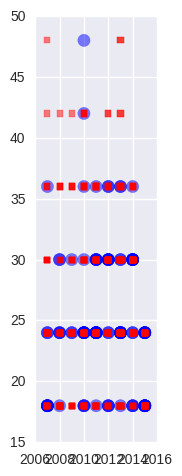

In [50]:
import pylab
import matplotlib

x1=data_female['start_year']
y1=data_female['total_duration']
x2=data_male['start_year']
y2=data_male['total_duration']


def my_circle_scatter(axes, x_array, y_array, radius=0.5, **kwargs):
    for x, y in zip(x_array, y_array):
        circle = pylab.Circle((x,y), radius=radius, **kwargs)
        axes.add_patch(circle)
    return True

def my_square_scatter(axes, x_array, y_array, size=0.5, **kwargs):
    size = float(size)
    for x, y in zip(x_array, y_array):
        square = pylab.Rectangle((x-size/2,y-size/2), size, size, **kwargs)
        axes.add_patch(square)
    return True

axes=pylab.axes()
my_circle_scatter(axes, x1, y1, radius=.5, alpha=.5, color='b')
my_square_scatter(axes, x2, y2, size=.5, alpha=.5, color='r')
pylab.axis('scaled')
pylab.rcParams['figure.figsize'] = 15, 20
pylab.show()

### Data Normalization and Standardization:
* Normalize Duration

In [157]:
data_female_dur = data_female['total_duration']
data_male_dur = data_male['total_duration']

female_norm_stand = normalize_standardize(data_female_dur)
male_norm_stand = normalize_standardize(data_male_dur)
data_female

,No Sciper,duration,gender,project_time,specialization,start_year,total_duration
9,154573,30.0,Madame,6.0,Biocomputing,2007.0,36.0
15,159998,18.0,Madame,6.0,"Signals, Images and Interfaces",2008.0,24.0
16,160148,18.0,Madame,6.0,None,2007.0,24.0
25,161024,12.0,Madame,6.0,None,2007.0,18.0
26,161091,24.0,Madame,6.0,None,2008.0,30.0
37,162618,12.0,Madame,6.0,None,2007.0,18.0
41,166029,12.0,Madame,6.0,None,2007.0,18.0
43,166079,18.0,Madame,6.0,Internet computing,2007.0,24.0
123,174579,18.0,Madame,6.0,Internet computing,2010.0,24.0
149,178057,12.0,Madame,6.0,None,2007.0,18.0


* Normalize the starting year

In [ ]:
data_female_dur = data_female['total_duration']
data_male_dur = data_male['total_duration']

female_norm_stand = normalize_standardize(data_female_dur)
male_norm_stand = normalize_standardize(data_male_dur)

### Plotting distributions for Normalized, Standardized Data

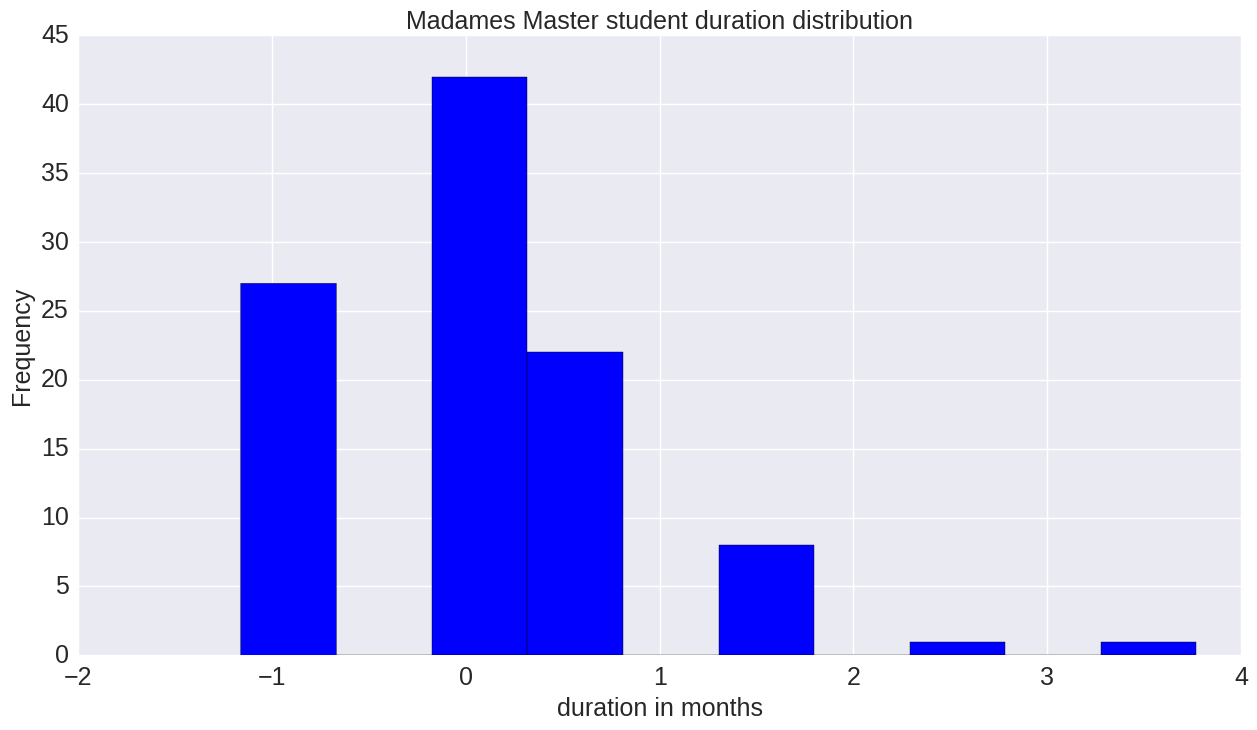

In [149]:
female_norm_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Madames Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

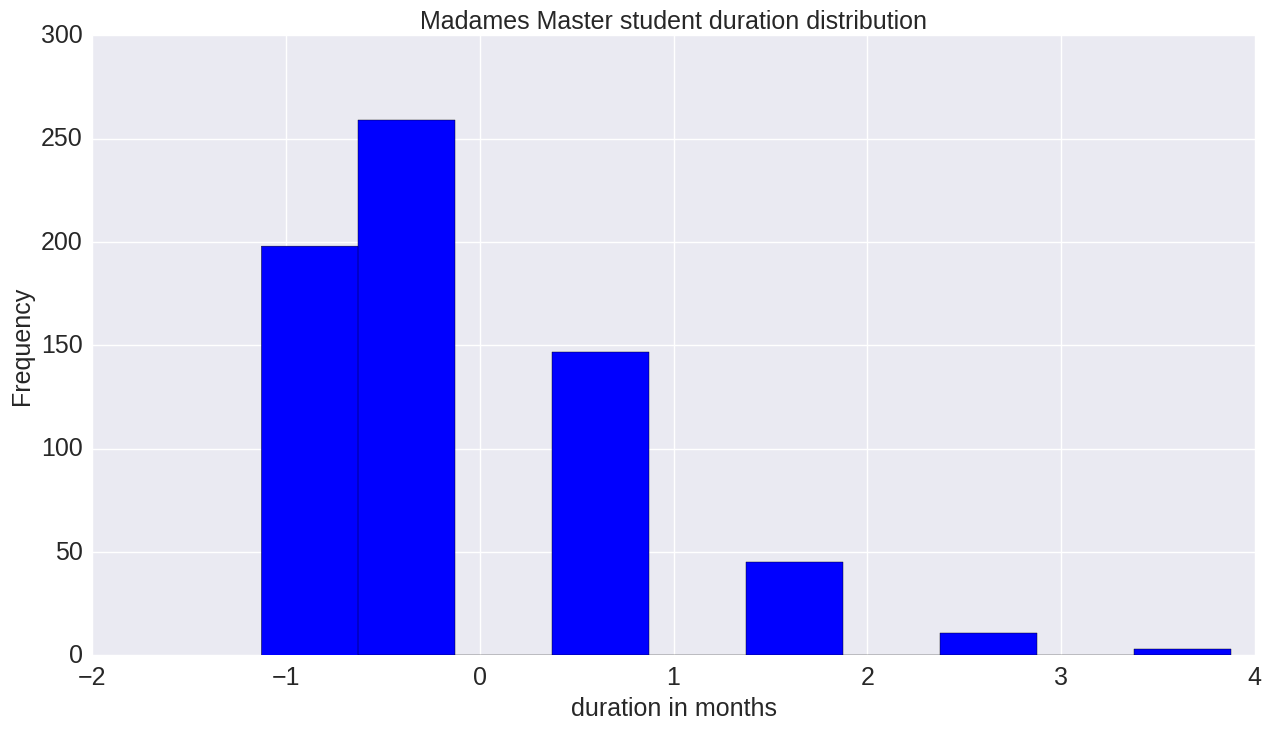

In [150]:
male_norm_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Monsieur Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

### K-S (Kolmorogorov-Smirnov) test to check for Normal Distribution

In [153]:
stats.kstest(female_norm_stand,'norm')

KstestResult(statistic=0.2529352189773969, pvalue=3.5002964422492511e-06)

Since the kstest returns a pvalue=3.5002964422492511e-06 (extremely smaller than 5%), we can reject with high confidence the null hypothesis that says that the Master duration for madames is a normal distribution => female_norm_stand is not normal.

In [155]:
stats.kstest(male_norm_stand,'norm')

KstestResult(statistic=0.23972527539751426, pvalue=0.0)

Since the kstest returns a pvalue=0.0, we can reject with high confidence the null hypothesis that says that the Master duration for monsieur is a normal distribution => male_norm_stand is not normal.

Since the two samples are not normal, and we have unpaired independent samples (since we want to compare two different subjects and there is no correlation between males and females the duration that it takes for males to graduate doesn't make the duration for females to graduate), the most adequate to apply here is Mann-Whitney test.

In [156]:
stats.mannwhitneyu(female_norm_stand, male_norm_stand, use_continuity=True, alternative='two-sided')

MannwhitneyuResult(statistic=24511.0, pvalue=7.214601150768051e-06)

Since pvalue=7.214601150768051e-06 is extremly less than the threshold of 5%, we can with a very high confidence greater reject the null hypothesis that says that the two samples have the same mean. So there is a significant statistical difference between males duration to graduate and females duration to graduate.